In [1]:
from __future__ import print_function

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,TimeDistributed
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import layers,models
import h5py
from keras.models import Model
from keras.layers import Layer
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import heapq
import warnings

from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

/home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/peppermint/.virtualenvs/cv/lib/python3.6/site-

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13490629357577604960
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6410313770835342218
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6069456372225395705
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5618597888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17200216036153251867
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Using TensorFlow backend.


In [2]:

class ScaleLayer(Layer):

    def __init__(self,scale, **kwargs):

        self.scale=scale;
        
        super(ScaleLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(ScaleLayer, self).build(input_shape)

       
    def call(self, inputs):

        output=tf.image.resize(inputs,[self.scale,self.scale],method=tf.image.ResizeMethod.BICUBIC)


        print(output.shape)

        return output

       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],self.scale,self.scale,3)



def vgg16_head(img_input):

    pooling = 'No'

    include_top = False;



    x = TimeDistributed(ScaleLayer(224))(img_input)

    x = TimeDistributed(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))(x)

    # Block 2
    x = TimeDistributed(layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))(x)

    # Block 3
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))(x)

    # Block 4
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))(x)

    # Block 5
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        elif pooling =='No':
            x = x;
    return x

In [3]:

class AttentionLayer(Layer):

    def __init__(self, **kwargs):

        
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)


        self.input_shape_r = input_shape;
        print('self.input_shape_r')
        print(self.input_shape_r)

        L_size = 256;

        self.w = self.add_weight(name='w', 
                              shape=[L_size,1],
                              initializer='uniform',
                              trainable=True)
        self.V = self.add_weight(name='V', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        self.U = self.add_weight(name='U', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        

        self.bias_w = self.add_weight(shape=[1,1],
                              initializer='uniform',
                              name='bias_w')
        self.bias_V = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_V')
        self.bias_U = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_U')
        
        self.Save = self.add_weight(name='ForSave', 
              shape=[10,10],
              initializer='uniform',
              trainable=False)
      

  
       
    def call(self, inputs):


        inputs_r = K.expand_dims(inputs,axis=-2)


        print('inputs')
        print(inputs_r.shape)


        dot_products_V = K.dot(inputs_r,self.V)
        dot_products_U = K.dot(inputs_r,self.U)

        dot_products_V += self.bias_V;
        dot_products_U += self.bias_U;


        print('dot product')
        print(dot_products_V.shape)

        tanh_V = K.tanh(dot_products_V);
        sigmoid_U = K.sigmoid(dot_products_U);

        print('tanh')
        print(tanh_V.shape)

        comb_UV = tanh_V*sigmoid_U;

        print('combUV')
        print(comb_UV.shape)

        attention_weights = K.dot(comb_UV,self.w);

        attention_weights +=self.bias_w;

        attention_weights = K.exp(attention_weights);


        print('attention_weights')
        print(attention_weights.shape)


        attention_weights /= K.cast(K.sum(attention_weights,
                                  axis=1,
                                  keepdims=True) + K.epsilon(),
                            K.floatx());
        print('attention_weights sum')
        print(attention_weights.shape)

        #attention_weights = K.expand_dims(attention_weights);
        attention_weights= K.squeeze(attention_weights,axis = -1);
        print('attention_weights last')
        print(attention_weights.shape)

        weighted_output = inputs * attention_weights;

        self.Save =  attention_weights;


        output = K.sum(weighted_output, axis=1)

        print('output')
        print(output.shape)

        return output


       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])
    
    
class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, D):
    # initialize the head model that will be placed on top of
    # the base, then add a FC layer
    headModel = baseModel.output
    headModel = TimeDistributed(layers.Flatten(name='flatten'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc1'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc2'))(headModel)
    headModel = AttentionLayer(name='attentionlayer')(headModel)
    headModel = layers.Dense(classes, activation='sigmoid', name='predictions')(headModel)
    # add a softmax layer
    #headModel = layers.Dense(classes, activation="softmax")(headModel)
    #headModel = layers.Dense(classes, activation='softmax', name='predictions2')(headModel)

    # return the model
    return headModel


In [4]:
import random
batch_size = 1
num_classes = 2
epochs = 100

# input image dimensions
img_rows, img_cols = 128, 128

# the data, split between train and test sets

#(x_train, y_train), (x_test, y_test) = mnist.load_data()


p='/home/peppermint/Data_Sci/Attention_ML/2548_many.h5';

db=h5py.File(p);


X_stk, y_stk = db['images'],db['labels'];

X =np.zeros((91,28,128,128,3))
y = np.zeros((91,))

for ij in range(91):
    X[ij,...] = X_stk[ij*28:(ij+1)*28,...]
    y[ij,...] = y_stk[(ij*28+(ij+1)*28)//2]

print(X.shape)
print(y.shape)


total_size = X.shape[0];
index_random = np.arange(total_size)
i = int(X.shape[0] * 3/4)

random.shuffle(index_random)

index_random=list(index_random)

X = X[list(index_random)]

y = y[list(index_random)]



print(list(index_random))


(91, 28, 128, 128, 3)
(91,)
[20, 37, 89, 1, 82, 75, 70, 26, 74, 53, 13, 27, 86, 29, 23, 22, 60, 64, 5, 72, 6, 84, 45, 68, 76, 58, 90, 31, 34, 46, 32, 49, 48, 38, 17, 40, 43, 67, 77, 10, 44, 25, 33, 88, 59, 85, 50, 66, 14, 81, 63, 8, 56, 51, 15, 79, 19, 80, 87, 0, 39, 36, 41, 71, 61, 2, 18, 83, 9, 35, 21, 7, 55, 52, 65, 30, 12, 3, 69, 54, 11, 24, 78, 16, 57, 47, 73, 62, 42, 4, 28]


In [6]:
val_acc_list = [];
acc_list = [];
epochs = 50;
batch_size =1 ;
kf = KFold(n_splits=5)
ep=1;
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]


    img_rows, img_cols = 128, 128

    pooling = 'No'
    num_sequence = 28;
    include_top = False;

    input_shape =  [num_sequence,img_rows, img_cols, 3];
    img_input = layers.Input(shape=input_shape)
    inputs = img_input


    x = vgg16_head(inputs);

    # Create model.
    base_model = models.Model(inputs, x, name='vgg16')

    weights ='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5';

    base_model.load_weights(weights)


    head_model = FCHeadNet.build(base_model, 1, 256)

    model = Model(inputs=base_model.input, outputs=head_model)

    Dont_Want_to_train_all = True;


    if (Dont_Want_to_train_all):

      for layer in base_model.layers:
        layer.trainable = False



    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))


    max_val=-1;
    save_acc=0;
    val_acc=history.history['val_accuracy'];
    acc=history.history['accuracy'];
    for h in range(len(val_acc)):
        if(max_val<=val_acc[h]):
            max_val=val_acc[h];
            save_acc=acc[h];
    print("Epoch "+str(ep))
    ep=ep+1;
    print("max_val :"+str(max_val))
    print("save_acc :"+str(save_acc))
    val_acc_list.append(max_val)
    acc_list.append(save_acc)

(?, 224, 224, 3)
self.input_shape_r
(None, 28, 256)
inputs
(?, 28, 1, 256)
dot product
(?, 28, 1, 256)
tanh
(?, 28, 1, 256)
combUV
(?, 28, 1, 256)
attention_weights
(?, 28, 1, 1)
attention_weights sum
(?, 28, 1, 1)
attention_weights last
(?, 28, 1)
output
(?, 256)


W0428 00:57:56.250262 139842270504768 deprecation_wrapper.py:119] From /home/peppermint/.virtualenvs/cv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 72 samples, validate on 19 samples
Epoch 1/50
72/72 [==============================] - 18s 253ms/step - loss: 0.7844 - accuracy: 0.5972 - val_loss: 0.6899 - val_accuracy: 0.5263
Epoch 2/50
72/72 [==============================] - 15s 205ms/step - loss: 0.6261 - accuracy: 0.6389 - val_loss: 0.7229 - val_accuracy: 0.5263
Epoch 3/50
72/72 [==============================] - 15s 203ms/step - loss: 0.6438 - accuracy: 0.6111 - val_loss: 0.6459 - val_accuracy: 0.6316
Epoch 4/50
72/72 [==============================] - 15s 204ms/step - loss: 0.5708 - accuracy: 0.6806 - val_loss: 0.6051 - val_accuracy: 0.6842
Epoch 5/50
72/72 [==============================] - 15s 204ms/step - loss: 0.5705 - accuracy: 0.7361 - val_loss: 0.5920 - val_accuracy: 0.7368
Epoch 6/50
72/72 [==============================] - 15s 205ms/step - loss: 0.5394 - accuracy: 0.7222 - val_loss: 0.5724 - val_accuracy: 0.7368
Epoch 7/50
72/72 [==============================] - 15s 205ms/step - loss: 0.4759 - accuracy: 0.77

Epoch 5/50
73/73 [==============================] - 15s 201ms/step - loss: 0.5129 - accuracy: 0.7534 - val_loss: 0.6169 - val_accuracy: 0.7222
Epoch 6/50
73/73 [==============================] - 15s 201ms/step - loss: 0.4517 - accuracy: 0.7397 - val_loss: 0.6249 - val_accuracy: 0.7222
Epoch 7/50
73/73 [==============================] - 15s 200ms/step - loss: 0.4058 - accuracy: 0.7945 - val_loss: 0.6482 - val_accuracy: 0.6111
Epoch 8/50
73/73 [==============================] - 15s 200ms/step - loss: 0.4504 - accuracy: 0.7945 - val_loss: 0.6409 - val_accuracy: 0.6667
Epoch 9/50
73/73 [==============================] - 15s 204ms/step - loss: 0.3762 - accuracy: 0.8356 - val_loss: 0.9523 - val_accuracy: 0.4444
Epoch 10/50
73/73 [==============================] - 15s 203ms/step - loss: 0.3138 - accuracy: 0.8493 - val_loss: 0.6738 - val_accuracy: 0.6111
Epoch 11/50
73/73 [==============================] - 15s 203ms/step - loss: 0.2492 - accuracy: 0.9315 - val_loss: 0.5070 - val_accuracy: 0.77

73/73 [==============================] - 17s 226ms/step - loss: 0.2798 - accuracy: 0.8767 - val_loss: 0.5818 - val_accuracy: 0.6111
Epoch 10/50
73/73 [==============================] - 16s 224ms/step - loss: 0.2701 - accuracy: 0.9041 - val_loss: 0.5705 - val_accuracy: 0.6667
Epoch 11/50
73/73 [==============================] - 16s 225ms/step - loss: 0.2421 - accuracy: 0.8904 - val_loss: 0.6609 - val_accuracy: 0.6667
Epoch 12/50
73/73 [==============================] - 16s 225ms/step - loss: 0.1437 - accuracy: 0.9726 - val_loss: 0.6479 - val_accuracy: 0.6111
Epoch 13/50
73/73 [==============================] - 16s 226ms/step - loss: 0.1114 - accuracy: 0.9863 - val_loss: 0.6078 - val_accuracy: 0.6667
Epoch 14/50
73/73 [==============================] - 16s 224ms/step - loss: 0.0921 - accuracy: 0.9589 - val_loss: 0.8422 - val_accuracy: 0.7222
Epoch 15/50
73/73 [==============================] - 16s 225ms/step - loss: 0.0622 - accuracy: 0.9863 - val_loss: 0.7000 - val_accuracy: 0.6111
Epoc

73/73 [==============================] - 17s 226ms/step - loss: 0.2287 - accuracy: 0.9452 - val_loss: 0.4521 - val_accuracy: 0.7222
Epoch 14/50
73/73 [==============================] - 17s 227ms/step - loss: 0.1852 - accuracy: 0.9315 - val_loss: 0.5215 - val_accuracy: 0.7778
Epoch 15/50
73/73 [==============================] - 16s 224ms/step - loss: 0.1422 - accuracy: 0.9589 - val_loss: 0.3250 - val_accuracy: 0.8889
Epoch 16/50
73/73 [==============================] - 16s 226ms/step - loss: 0.0987 - accuracy: 1.0000 - val_loss: 0.7340 - val_accuracy: 0.6667
Epoch 17/50
73/73 [==============================] - 17s 227ms/step - loss: 0.0830 - accuracy: 0.9863 - val_loss: 0.2953 - val_accuracy: 0.8889
Epoch 18/50
73/73 [==============================] - 17s 226ms/step - loss: 0.0481 - accuracy: 1.0000 - val_loss: 0.2880 - val_accuracy: 0.8889
Epoch 19/50
73/73 [==============================] - 16s 226ms/step - loss: 0.0545 - accuracy: 1.0000 - val_loss: 0.3270 - val_accuracy: 0.8889
Epoc

73/73 [==============================] - 16s 225ms/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.5175 - val_accuracy: 0.8889
Epoch 18/50
73/73 [==============================] - 16s 226ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.3916 - val_accuracy: 0.8889
Epoch 19/50
73/73 [==============================] - 17s 227ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.5281 - val_accuracy: 0.8889
Epoch 20/50
73/73 [==============================] - 16s 226ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.5279 - val_accuracy: 0.8889
Epoch 21/50
73/73 [==============================] - 17s 230ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.4935 - val_accuracy: 0.8889
Epoch 22/50
73/73 [==============================] - 17s 228ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.5226 - val_accuracy: 0.8889
Epoch 23/50
73/73 [==============================] - 17s 228ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.4223 - val_accuracy: 0.8889
Epoc

Text(0.5, 0, 'fold')

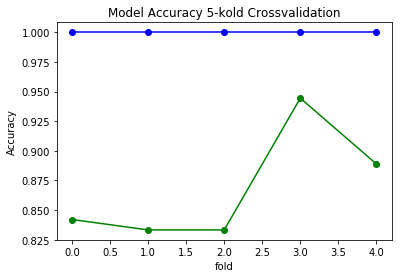

In [12]:
plt.plot(val_acc_list,'go-')
plt.plot(acc_list,'bo-')
plt.title('Model Accuracy 5-kold Crossvalidation')
plt.ylabel('Accuracy')
plt.xlabel('fold')

In [14]:
print("Average Train accuracy "+str(np.mean(acc_list)*100)+'%')

print("Average Validation accuracy "+str(np.mean(val_acc_list)*100)+'%')


Average Train accuracy 100.0%
Average Validation accuracy 86.84210419654846%


In [15]:
acc_list

[1.0, 1.0, 1.0, 1.0, 1.0]

In [16]:
val_acc_list

[0.8421052694320679,
 0.8333333134651184,
 0.8333333134651184,
 0.9444444179534912,
 0.8888888955116272]